Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

# Needed for using CRF
!pip install git+https://www.github.com/keras-team/keras-contrib.git

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
# from keras.layers import CuDNNLSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-uxfm018m
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-uxfm018m
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=85176b08f27ac7a6e0d2c109825e4a1a0f2778c03165e94c8f3cd83c19023f6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-p9rzm4gk/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


Using TensorFlow backend.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=025b9e34ab08647dea41c33b8d94fd77ffae31cdc1553ed0ba65daacabdd7bec
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1iTLWWB9aFjtjVz7Kq4ku2syjhINCz2_q'
DATA_TRAINING_FILENAME = 'ner_medical_training.csv'
DATA_DEV_FILE_ID = '1fB1Mp-6_zxGC3NO5sMX23B-LPyYzc9I9'
DATA_DEV_FILENAME = 'ner_medical_dev.csv'
DATA_TEST_FILE_ID = '17vmu2VXPwvOKuQ66kDY7t38dFqkYccvx'
DATA_TEST_FILENAME = 'ner_medical_test.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1000
Number of dev sentences:  1000
Number of test sentences:  1000
Number of words in the training dataset:  10405
Number of words in the dev dataset:  10246
Number of words in the test dataset:  10814
Tags in the training dataset: ['I-Chemical', 'B-Disease', 'I-Disease', 'B-Chemical', 'O']
Number of Labels in the training dataset:  5
Tags in the dev dataset: ['I-Chemical', 'B-Disease', 'I-Disease', 'B-Chemical', 'O']
Number of Labels in the dev dataset:  5
Tags in the test dataset: ['I-Chemical', 'B-Disease', 'I-Disease', 'B-Chemical', 'O']
Number of Labels in the test dataset:  5
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Naloxone,B-Chemical
1,Sentence: 1,reverses,O
2,Sentence: 1,the,O
3,Sentence: 1,antihypertensive,O
4,Sentence: 1,effect,O
5,Sentence: 1,of,O
6,Sentence: 1,clonidine,B-Chemical
7,Sentence: 1,.,O
8,Sentence: 2,In,O
9,Sentence: 2,unanesthetized,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Intravenous', 'O'),
 ('administration', 'O'),
 ('of', 'O'),
 ('prochlorperazine', 'B-Chemical'),
 ('by', 'O'),
 ('15', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('infusion', 'O'),
 ('versus', 'O'),
 ('2', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('bolus', 'O'),
 ('does', 'O'),
 ('not', 'O'),
 ('affect', 'O'),
 ('the', 'O'),
 ('incidence', 'O'),
 ('of', 'O'),
 ('akathisia', 'B-Disease'),
 (':', 'O'),
 ('a', 'O'),
 ('prospective', 'O'),
 (',', 'O'),
 ('randomized', 'O'),
 (',', 'O'),
 ('controlled', 'O'),
 ('trial', 'O'),
 ('.', 'O')]

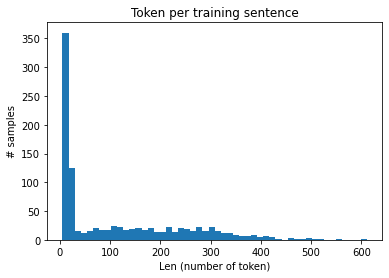

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

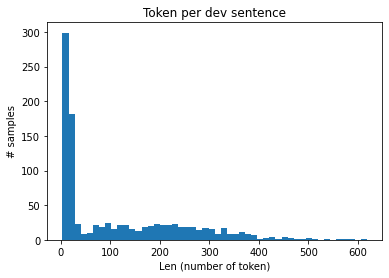

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

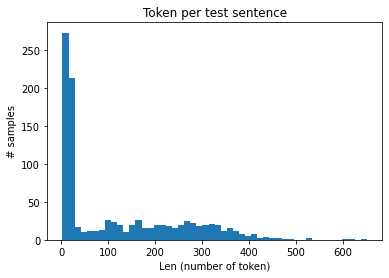

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'delirium'
print(word2idx['delirium'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Chemical'
print(tag2idx['B-Chemical'])
# Tag of index 4
print(idx2tag[4])

6000
reliability
3
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1000
Points in y_train before removal: 1000
Points in X_train before removal: 50
Points in y_train before removal: 50


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['delirium'])
print(tag2idx['B-Chemical'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[14525, 15020, 798, 10715, 3209, 8088, 7092, 18288, 17884, 3209, 3368, 12007, 3707, 13793]
[3, 4, 1, 2, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4]
[3384, 1574, 15370, 3209, 284, 4521, 4868, 18288, 4153, 5295, 18191, 13793]
[1, 2, 2, 4, 3, 0, 1, 4, 4, 4, 4, 4]
[10280, 13228, 17078, 6000, 13793, 12614, 4819, 2344, 11058, 10458, 13793]
[3, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]
6000
3
I-Disease
8,770
18533
5


In [11]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 1.x
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['delirium'])
print(tag2idx['B-Chemical'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-e4_2pmyi
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-e4_2pmyi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[14525, 15020, 798, 10715, 3209, 8088, 7092, 18288, 17884, 3209, 3368, 12007, 3707, 13793]
[3, 4, 1, 2, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4]
[3384, 1574, 15370, 3209, 284, 4521, 4868, 18288, 4153, 5295, 18191, 13793]
[1, 2, 2, 4, 3, 0, 1, 4, 4, 4, 4, 4]
[10280, 13228, 17078, 6000, 13793, 12614, 4819, 2344, 11058, 10458, 13793]
[3, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]
6000
3
I-Disease
8,770
18533
5


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['crf_viterbi_accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [5]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [6]:
# Model creation function
def create_model(maxlen, n_words):
  input = Input(shape=(maxlen,))
  word_embedding_size = 150

  model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
  model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5))(model)
  model = TimeDistributed(Dense(n_tags,
                                activation="relu"))(model)  
  crf = CRF(n_tags)
  out = crf(model)
  model = Model(input, out)

  adam = k.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
  model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
  model.summary()

  return model

In [7]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.0001, verbose=1)
  callbacks_list = [early_stopping]

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=(round(0.05*len(X_train_df)) if round(0.05*len(X_train_df)) > 10 else 10),
                      epochs=100,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [8]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [9]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=n_words - 1)
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=n_words - 1)
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1)

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  model = None
  model = create_model(maxlen, n_words)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_1 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________

Train on 50 samples,

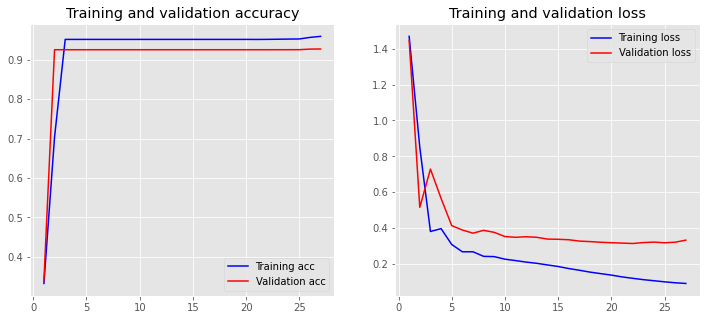

1000/1000 [==============================] - 17s 17ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.11538461538461539,0.0005272716620774503,0.0010497463113081004,17069.0
micro avg,0.11538461538461539,0.00024085422966788877,0.0004807050340499399,37367.0
macro avg,0.057692307692307696,0.00026363583103872516,0.0005248731556540502,37367.0
weighted avg,0.05270693392565633,0.00024085422966788877,0.0004795172153964184,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_2 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 83s 2s/step - lo

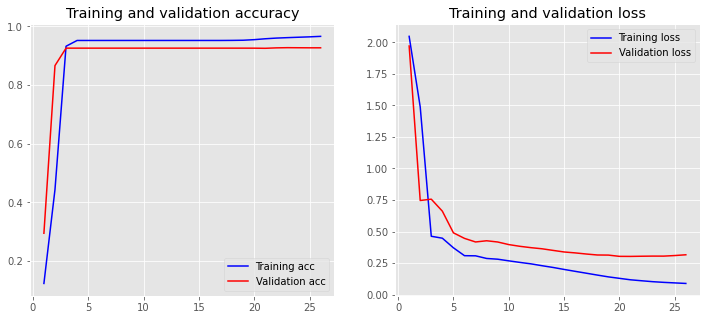

1000/1000 [==============================] - 17s 17ms/step
F1-score: 1.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.020964360587002098,0.0004926593753079121,0.0009626955475330927,20298.0
Disease,0.12641272498953537,0.01769289354971,0.031041216980162406,17069.0
micro avg,0.10886252616887648,0.008349613295153477,0.015509656252330176,37367.0
macro avg,0.07368854278826874,0.009092776462508957,0.01600195626384775,37367.0
weighted avg,0.06913248037148681,0.008349613295153477,0.014702366442535362,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_3 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 84s 2s/step - lo

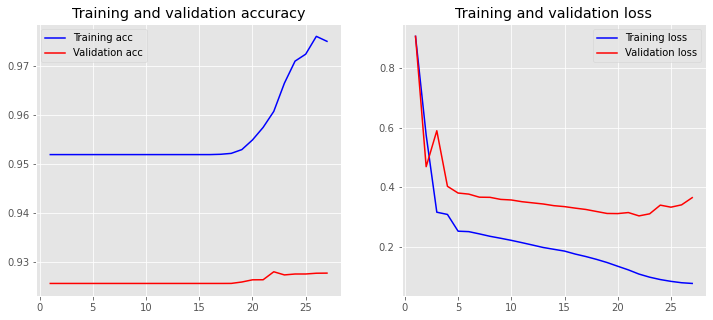

1000/1000 [==============================] - 17s 17ms/step
F1-score: 3.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.03800045238633793,0.008276677505172924,0.013592782879566329,20298.0
Disease,0.2728471001757469,0.036381744683344076,0.06420263634013958,17069.0
micro avg,0.11781394654322831,0.021114887467551583,0.0358115468409586,37367.0
macro avg,0.15542377628104243,0.0223292110942585,0.038897709609852955,37367.0
weighted avg,0.14527685753305622,0.021114887467551583,0.03671103129979072,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_4 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 83s 2s/step - lo

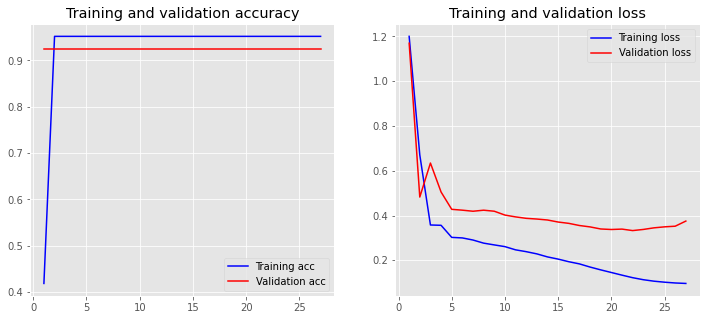

1000/1000 [==============================] - 18s 18ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_5 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 86s 2s/step - lo

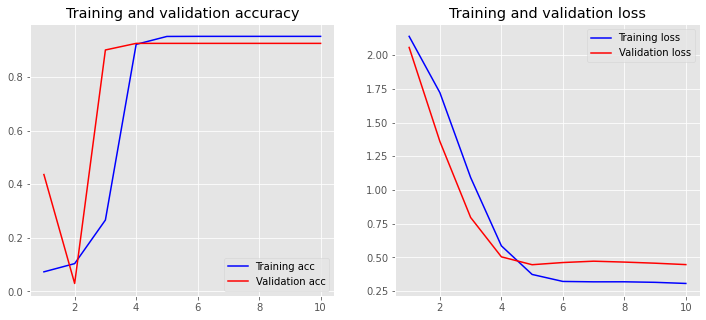

1000/1000 [==============================] - 18s 18ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_6 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 85s 2s/step - lo

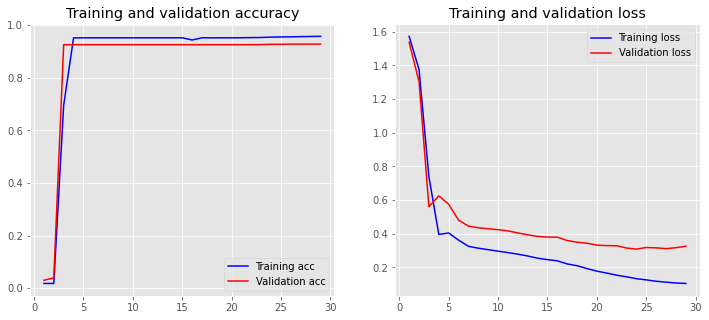

1000/1000 [==============================] - 17s 17ms/step
F1-score: 0.4%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.05598755832037325,0.0042181732966196026,0.007845273767365839,17069.0
micro avg,0.05598755832037325,0.0019268338373431102,0.0037254546865702533,37367.0
macro avg,0.027993779160186624,0.0021090866483098013,0.0039226368836829196,37367.0
weighted avg,0.025574748654439775,0.0019268338373431102,0.003583669492738713,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_7 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 82s 2s/step - lo

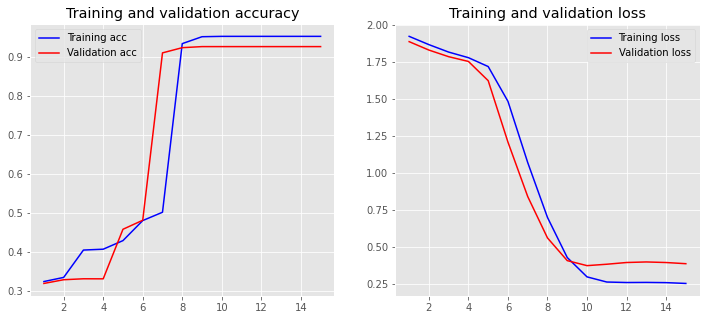

1000/1000 [==============================] - 18s 18ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_8 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 84s 2s/step - lo

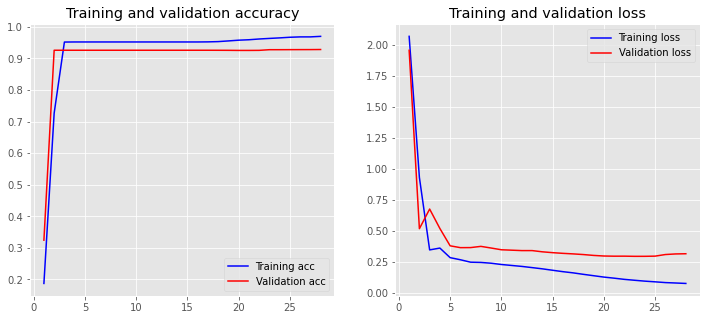

1000/1000 [==============================] - 18s 18ms/step
F1-score: 4.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.2028860650441525,0.04640851315400532,0.07553827031795037,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.19130787977254265,0.025209409371905692,0.04454848549336738,37367.0
macro avg,0.10144303252207625,0.02320425657700266,0.03776913515897518,37367.0
weighted avg,0.110209044029925,0.025209409371905692,0.041032884922893365,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_9 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 85s 2s/step - lo

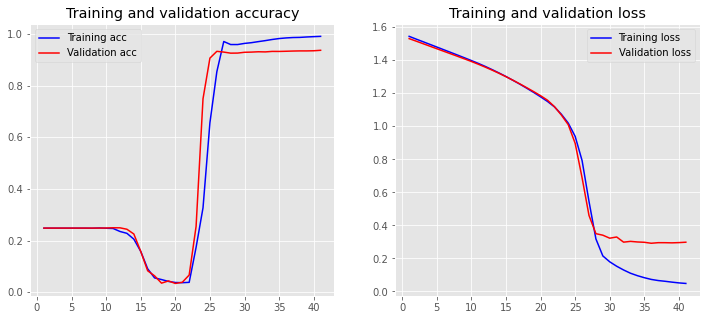

1000/1000 [==============================] - 18s 18ms/step
F1-score: 21.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8377581120943953,0.15390678884619174,0.2600407874474549,20298.0
Disease,0.285908884516422,0.11066846329603375,0.15957087345835444,17069.0
micro avg,0.48500386996904027,0.13415580592501405,0.21017546066285142,37367.0
macro avg,0.5618334983054086,0.13228762607111275,0.20980583045290468,37367.0
weighted avg,0.5856770120454637,0.13415580592501405,0.2141467910902425,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_10 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 50 samples, validate on 1000 samples
Epoch 1/100
50/50 [==============================] - 83s 2s/step - l

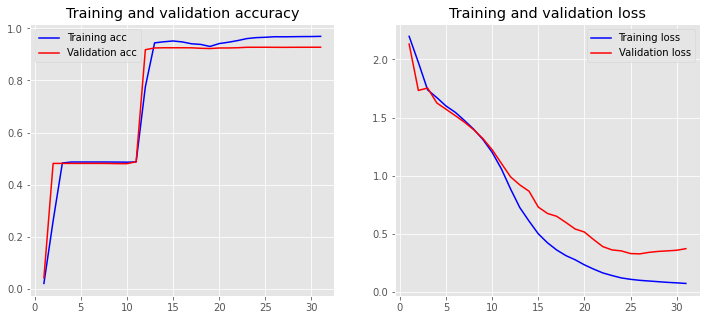

1000/1000 [==============================] - 19s 19ms/step
F1-score: 7.5%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.19621910944083817,0.10094323041771633,0.1333075435203095,17069.0
micro avg,0.19621910944083817,0.0461102041908636,0.07467279188697236,37367.0
macro avg,0.09810955472041909,0.050471615208858164,0.06665377176015475,37367.0
weighted avg,0.08963159951416134,0.0461102041908636,0.06089400969700974,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_11 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 89s 1s/step - l

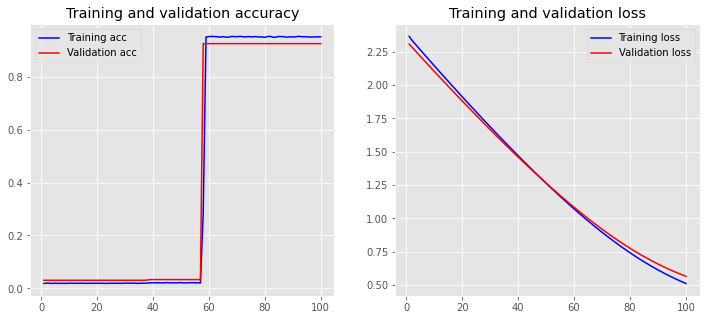

1000/1000 [==============================] - 18s 18ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_12 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 85s 1s/step - l

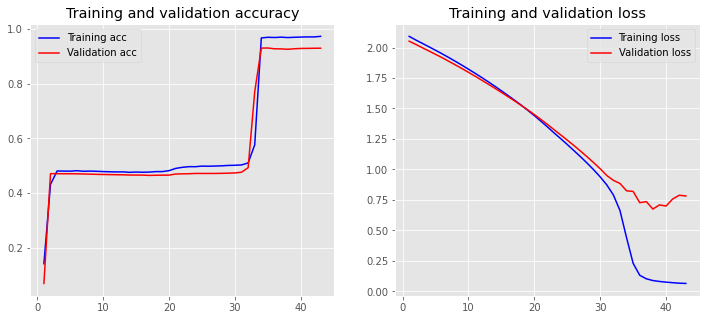

1000/1000 [==============================] - 19s 19ms/step
F1-score: 22.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6599703954324382,0.15375899103359936,0.24941063651256642,20298.0
Disease,0.2951144366197183,0.15712695529908022,0.2050693886913637,17069.0
micro avg,0.4199898675544619,0.15529745497363984,0.22675054704595185,37367.0
macro avg,0.4775424160260783,0.1554429731663398,0.22724001260196508,37367.0
weighted avg,0.4933065915152301,0.15529745497363984,0.2291558459470913,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_13 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 89s 1s/step - l

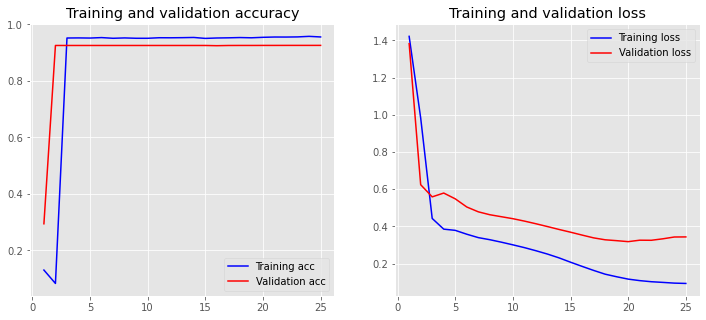

1000/1000 [==============================] - 19s 19ms/step
F1-score: 0.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0016488046166529267,9.853187506158242e-05,0.00018595137371577334,20298.0
Disease,0.016118633139909737,0.0014646435057706954,0.0026852846401718583,17069.0
micro avg,0.009768451519536902,0.0007225626890036663,0.0013455931823278763,37367.0
macro avg,0.008883718878281332,0.0007815876904161389,0.0014356180069438158,37367.0
weighted avg,0.008258527181040502,0.0007225626890036663,0.0013276303826043358,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_14 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 88s 1s/step - l

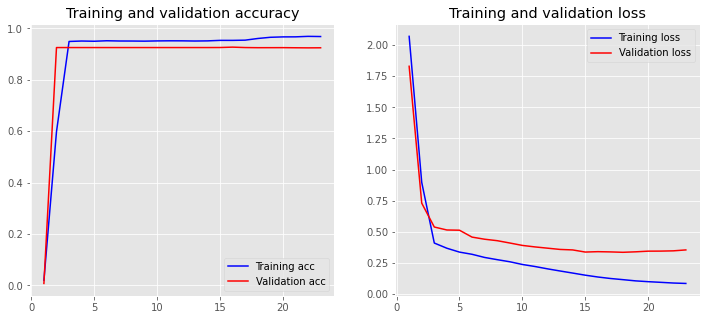

1000/1000 [==============================] - 19s 19ms/step
F1-score: 6.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.14337240757439135,0.07833284067395803,0.1013126035427552,20298.0
Disease,0.1586608442503639,0.006385845685160232,0.012277539986483442,17069.0
micro avg,0.1442642438651609,0.04546792624508256,0.0691437408432362,37367.0
macro avg,0.15101662591237763,0.04235934317955913,0.05679507176461932,37367.0
weighted avg,0.15035606496251927,0.04546792624508256,0.0606419717060543,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_15 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 88s 1s/step - l

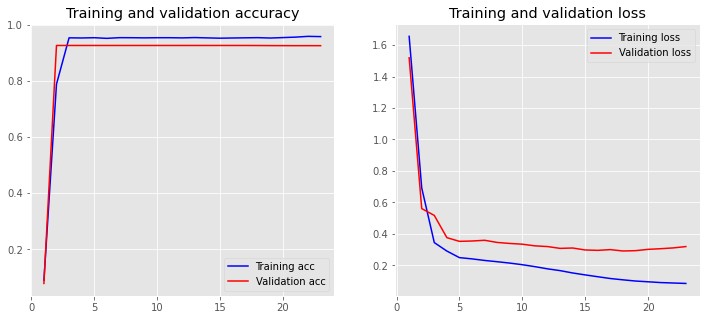

1000/1000 [==============================] - 20s 20ms/step
F1-score: 0.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.006006006006006006,0.00019706375012316484,0.00038160656363289447,20298.0
Disease,0.019726858877086494,0.0007616146230007616,0.0014666064981949459,17069.0
micro avg,0.012830188679245283,0.0004549468782615677,0.0008787346221441125,37367.0
macro avg,0.01286643244154625,0.0004793391865619632,0.0009241065309139202,37367.0
weighted avg,0.012273601415229997,0.0004549468782615677,0.0008772274024221913,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_16 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 89s 1s/step - l

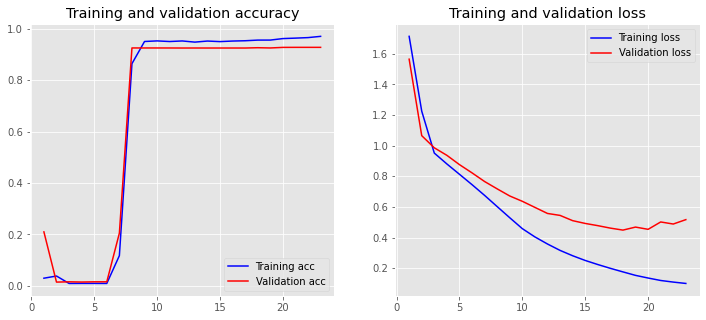

1000/1000 [==============================] - 20s 20ms/step
F1-score: 1.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.14634146341463414,0.016848950635530595,0.03021868787276342,20298.0
Disease,0.05512820512820513,0.002519186829925596,0.004818197097876633,17069.0
micro avg,0.12351620147577799,0.010303208713570797,0.019019859697658334,37367.0
macro avg,0.10073483427141963,0.009684068732728096,0.017518442485320026,37367.0
weighted avg,0.10467584654169661,0.010303208713570797,0.018615910635186347,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_17 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 89s 1s/step - l

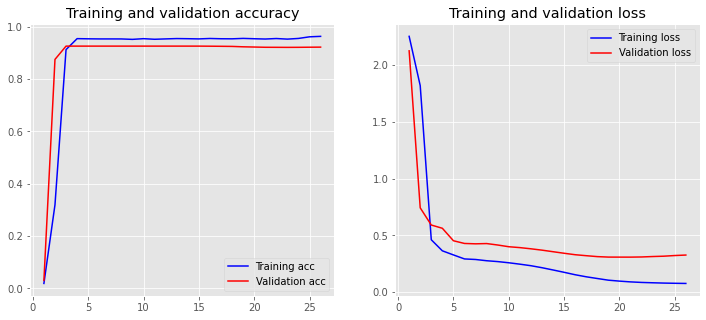

1000/1000 [==============================] - 20s 20ms/step
F1-score: 9.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.2193228582117471,0.11552862350970539,0.15133914165859955,20298.0
Disease,0.002898550724637681,5.8585740230827815e-05,0.00011485012059262662,17069.0
micro avg,0.21255776026094048,0.06278266920009634,0.09693413767457235,37367.0
macro avg,0.11111070446819239,0.0577936046249681,0.07572699588959608,37367.0
weighted avg,0.12046165703162906,0.06278266920009634,0.08226087922751757,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_18 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 89s 1s/step - l

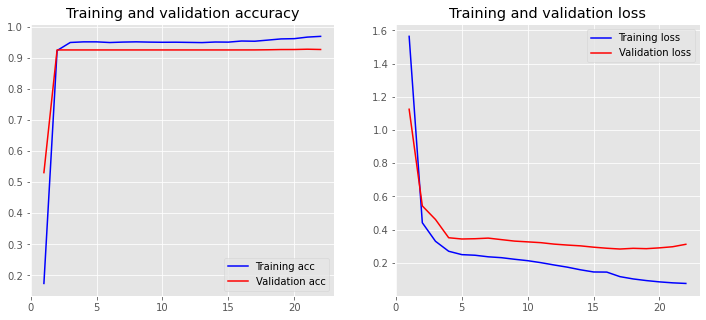

1000/1000 [==============================] - 20s 20ms/step
F1-score: 1.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.2971938775510204,0.011478963444674353,0.02210416469025709,20298.0
Disease,0.04878048780487805,0.00011717148046165563,0.000233781414377557,17069.0
micro avg,0.28484848484848485,0.006288971552439318,0.012306242144951823,37367.0
macro avg,0.17298718267794921,0.005798067462568004,0.011168973052317323,37367.0
weighted avg,0.18372027384783568,0.006288971552439319,0.012113917356085553,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_19 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 90s 1s/step - l

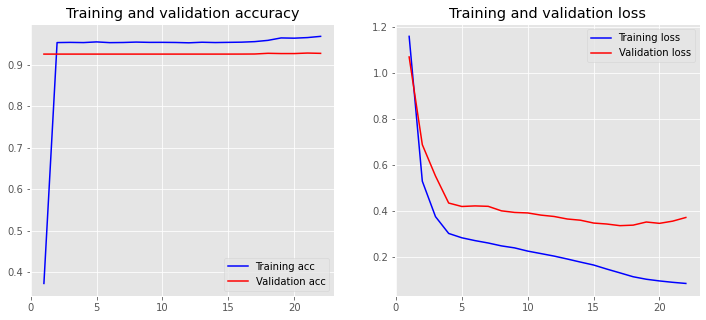

1000/1000 [==============================] - 21s 21ms/step
F1-score: 0.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.01306532663316583,0.0006404571879002857,0.0012210585638472737,20298.0
Disease,0.06778711484593837,0.007088874567930166,0.012835472578763127,17069.0
micro avg,0.04820143884892086,0.003586051863944122,0.006675467656362865,37367.0
macro avg,0.0404262207395521,0.0038646658779152255,0.0070282655713052,37367.0
weighted avg,0.0380618798219103,0.003586051863944122,0.006526446548448625,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_20 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 63 samples, validate on 1000 samples
Epoch 1/100
63/63 [==============================] - 89s 1s/step - l

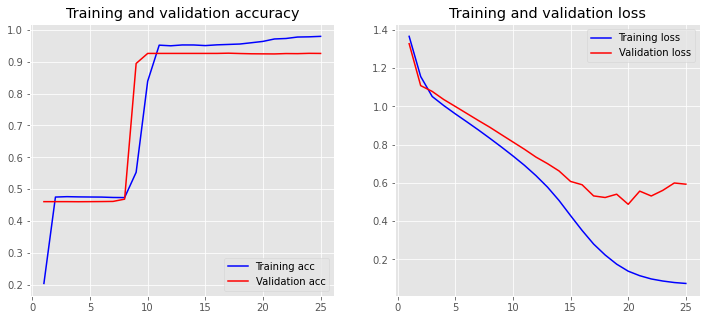

1000/1000 [==============================] - 20s 20ms/step
F1-score: 5.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.09855284850705258,0.053010148783131344,0.0689390056381343,20298.0
Disease,0.24780553679945982,0.021500966664713808,0.03956873315363881,17069.0
micro avg,0.1163803532542947,0.03861696149008483,0.0579913997508339,37367.0
macro avg,0.1731791926532562,0.037255557723922576,0.054253869395886556,37367.0
weighted avg,0.16673049553419145,0.03861696149008483,0.05552285820757115,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_21 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 90s 1s/step - l

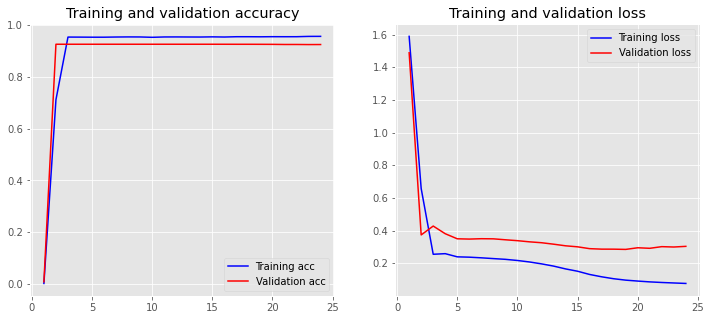

1000/1000 [==============================] - 20s 20ms/step
F1-score: 0.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.013719512195121951,0.0008867868755542418,0.0016658954187875985,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.012875536480686695,0.00048170845933577755,0.0009286727718302593,37367.0
macro avg,0.006859756097560976,0.0004433934377771209,0.0008329477093937992,37367.0
weighted avg,0.0074525291978640345,0.00048170845933577755,0.000904925340823472,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_22 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 90s 1s/step - l

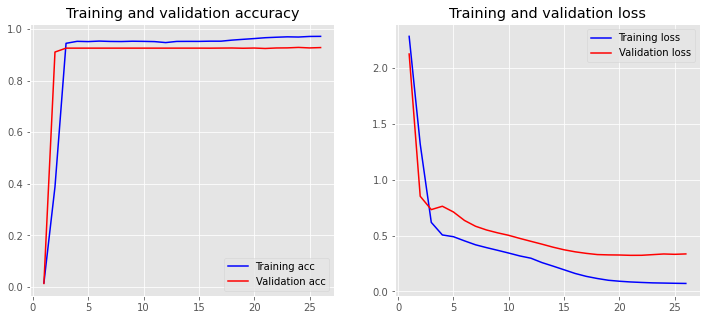

1000/1000 [==============================] - 21s 21ms/step
F1-score: 11.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.1868950940037824,0.08276677505172923,0.11472667053641546,20298.0
Disease,0.40532757379409645,0.06596754349991212,0.11346803043281099,17069.0
micro avg,0.23846349961757457,0.07509299649423289,0.11421826026783896,37367.0
macro avg,0.2961113338989394,0.07436715927582067,0.11409735048461322,37367.0
weighted avg,0.28667361509300204,0.07509299649423289,0.11415173200968266,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_23 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 91s 1s/step - l

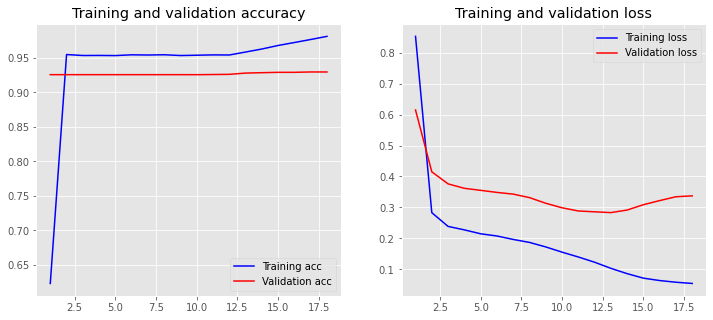

1000/1000 [==============================] - 21s 21ms/step
F1-score: 2.8%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.11601150527325024,0.03544437283965083,0.054299048644767554,17069.0
micro avg,0.11601150527325024,0.01619075654989697,0.028415762528768027,37367.0
macro avg,0.05800575263662512,0.017722186419825415,0.027149524322383777,37367.0
weighted avg,0.05299329310646047,0.01619075654989697,0.024803448532596604,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_24 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 92s 1s/step - l

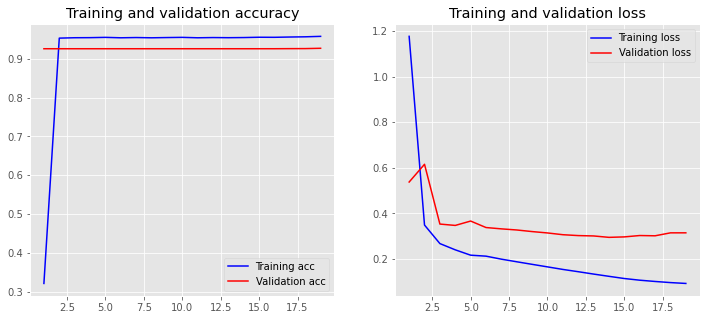

1000/1000 [==============================] - 22s 22ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_25 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 93s 1s/step - l

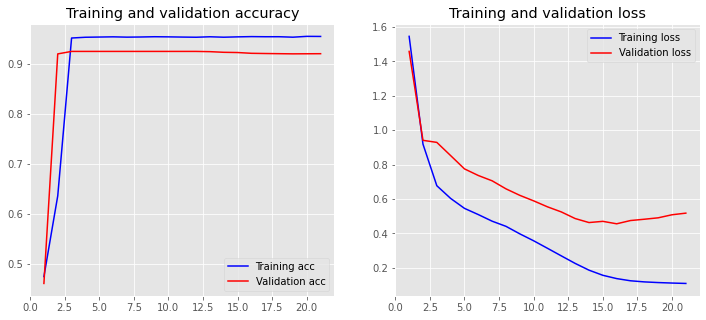

1000/1000 [==============================] - 22s 22ms/step
F1-score: 7.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.16971966400161928,0.08261897723913686,0.11113688326319628,20298.0
Disease,0.0035294117647058825,0.00017575722069248346,0.00033484011384563874,17069.0
micro avg,0.15655577299412915,0.04495945620467257,0.06985737452700735,37367.0
macro avg,0.08662453788316259,0.04139736722991467,0.05573586168852096,37367.0
weighted avg,0.09380504908921328,0.04495945620467257,0.06052323821499154,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_26 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 92s 1s/step - l

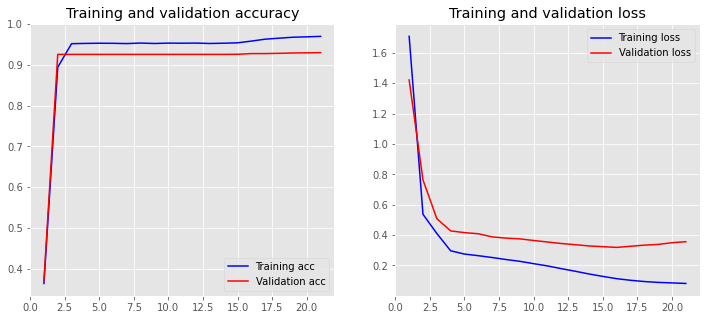

1000/1000 [==============================] - 22s 22ms/step
F1-score: 3.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.1857405140758874,0.029904424081190265,0.05151489433930238,20298.0
Disease,0.042136945071482315,0.0032808014529263577,0.006087618219371671,17069.0
micro avg,0.1442244942353709,0.01774292825220114,0.031598513011152414,37367.0
macro avg,0.11393872957368487,0.016592612767058312,0.028801256279337027,37367.0
weighted avg,0.12014334760985614,0.01774292825220114,0.030764013185046027,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_27 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 92s 1s/step - l

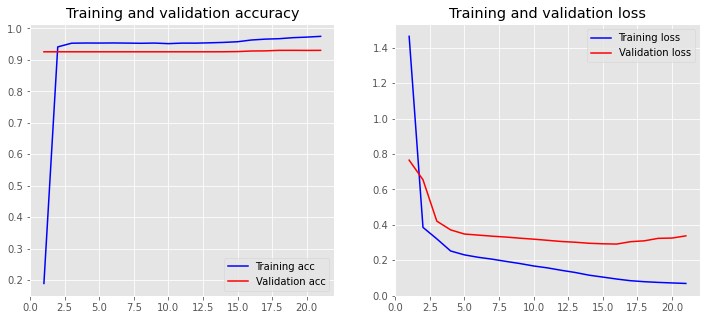

1000/1000 [==============================] - 22s 22ms/step
F1-score: 6.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.22863428668133357,0.06655828160409892,0.10310222459648184,20298.0
Disease,0.28846153846153844,0.0026363583103872516,0.005224963715529753,17069.0
micro avg,0.23017312448474855,0.03735916717959697,0.06428439860011052,37367.0
macro avg,0.258547912571436,0.034597319957243085,0.0541635941560058,37367.0
weighted avg,0.25596298207128504,0.03735916717959697,0.05839253513848491,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_28 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 92s 1s/step - l

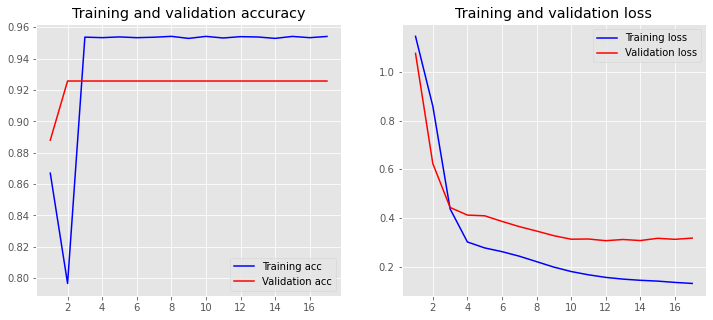

1000/1000 [==============================] - 22s 22ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_29 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_29 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 94s 1s/step - l

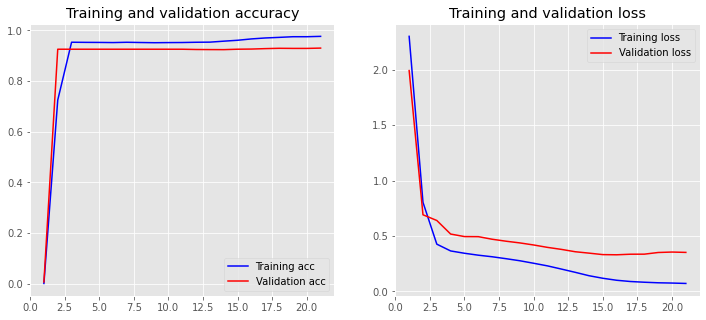

1000/1000 [==============================] - 22s 22ms/step
F1-score: 8.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.2339264839589557,0.08872795349295497,0.12865664178304817,20298.0
Disease,0.05798479087452472,0.003573730154080497,0.006732520280337729,17069.0
micro avg,0.21277568277911096,0.04983006396017877,0.08074938202003556,37367.0
macro avg,0.14595563741674022,0.04615084182351773,0.06769458103169294,37367.0
weighted avg,0.1535574749601559,0.04983006396017877,0.07296250444449372,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_30 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_30 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 75 samples, validate on 1000 samples
Epoch 1/100
75/75 [==============================] - 93s 1s/step - l

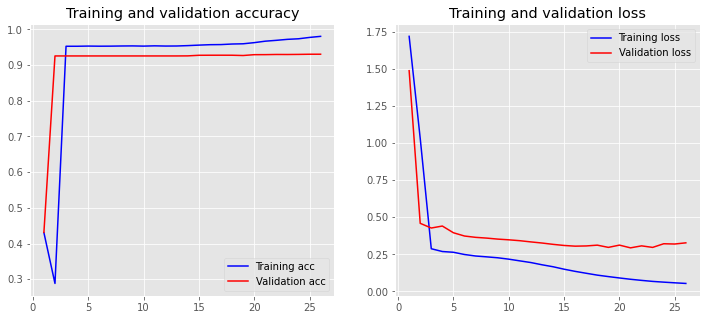

1000/1000 [==============================] - 23s 23ms/step
F1-score: 10.6%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.24750912498766894,0.146991622239147,0.18444460780710137,17069.0
micro avg,0.24750912498766894,0.06714480691519255,0.10563320983496126,37367.0
macro avg,0.12375456249383447,0.0734958111195735,0.09222230390355068,37367.0
weighted avg,0.1130605415049247,0.06714480691519255,0.08425308455748155,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_1 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________

Train on 88 samples,

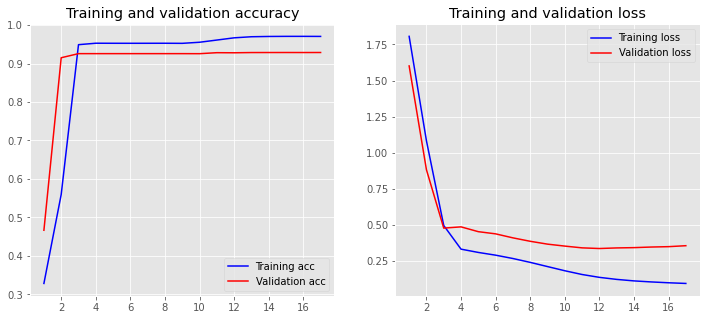

1000/1000 [==============================] - 21s 21ms/step
F1-score: 11.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.2606317774634606,0.1361710513351069,0.17888230916092285,20298.0
Disease,0.25225225225225223,0.0016404007264631789,0.0032596041909196743,17069.0
micro avg,0.2605449794699515,0.07471833435919394,0.11613252084936462,37367.0
macro avg,0.25644201485785645,0.06890572603078504,0.09107095667592126,37367.0
weighted avg,0.2568040654226193,0.07471833435919394,0.09865901183619824,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_2 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 111s 1s/step - l

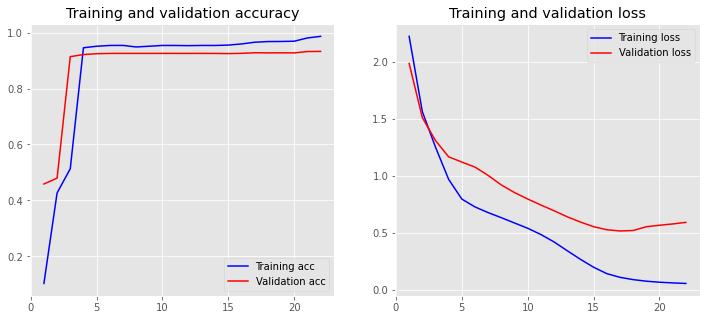

1000/1000 [==============================] - 21s 21ms/step
F1-score: 14.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.769774011299435,0.05369987190856242,0.10039605784286636,20298.0
Disease,0.24970951727051865,0.13849668990567696,0.17817304793488092,17069.0
micro avg,0.31737572360562344,0.09243450103032087,0.14317098445595855,37367.0
macro avg,0.5097417642849769,0.0960982809071197,0.13928455288887365,37367.0
weighted avg,0.5322119686259644,0.09243450103032087,0.13592407571640708,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_3 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 110s 1s/step - l

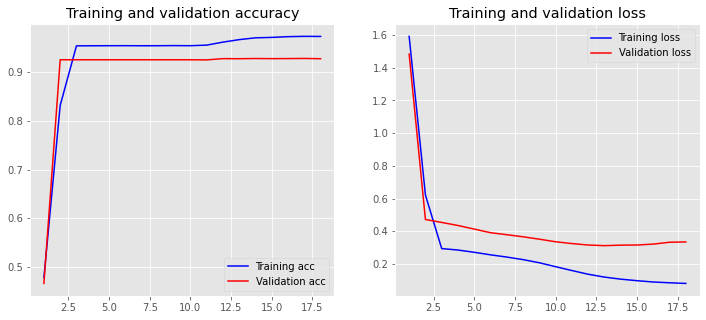

1000/1000 [==============================] - 21s 21ms/step
F1-score: 9.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.24772462077012836,0.10459158537786974,0.14708327559927947,20298.0
Disease,0.0026666666666666666,5.8585740230827815e-05,0.00011465260261407934,17069.0
micro avg,0.23745108999441028,0.056841598201621754,0.09172568664708931,37367.0
macro avg,0.1251956437183975,0.05232508555905028,0.07359896410094678,37367.0
weighted avg,0.13578375801443515,0.056841598201621754,0.07994897458688668,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_4 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 109s 1s/step - l

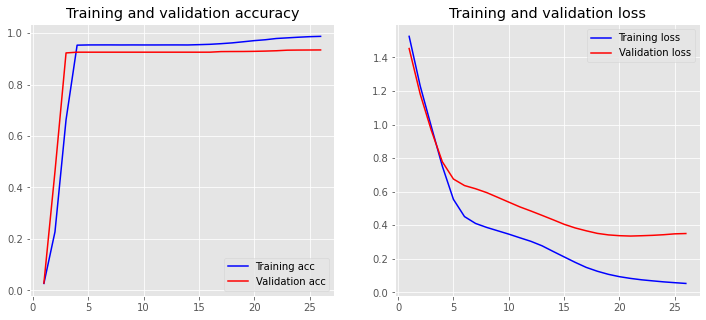

1000/1000 [==============================] - 21s 21ms/step
F1-score: 14.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7665198237885462,0.051433638782146025,0.096398891966759,20298.0
Disease,0.2507255389718076,0.1417189056183725,0.18108320544971365,17069.0
micro avg,0.3145322434150772,0.09267535525998875,0.14316720755731027,37367.0
macro avg,0.5086226813801769,0.09657627220025926,0.13874104870823634,37367.0
weighted avg,0.5309083846166321,0.09267535525998875,0.13508212976590137,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_5 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 108s 1s/step - l

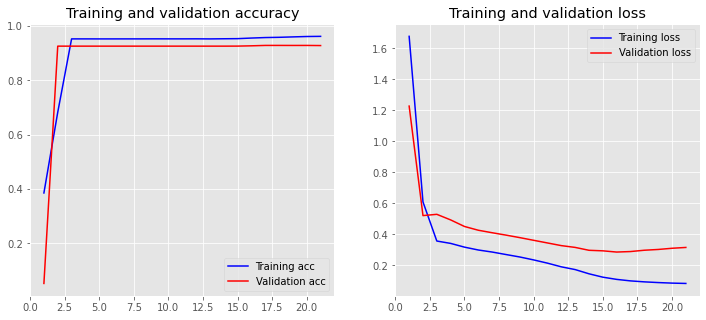

1000/1000 [==============================] - 21s 21ms/step
F1-score: 1.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0041928721174004195,9.853187506158242e-05,0.00019253910950661854,20298.0
Disease,0.2282410225197809,0.02196965258656043,0.040081231295425394,17069.0
micro avg,0.17783018867924527,0.01008911606497712,0.019094891989768787,37367.0
macro avg,0.11621694731859065,0.011034092230811006,0.020136885202466006,37367.0
weighted avg,0.10653659463240651,0.01008911606497712,0.01841343152584851,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_6 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 108s 1s/step - l

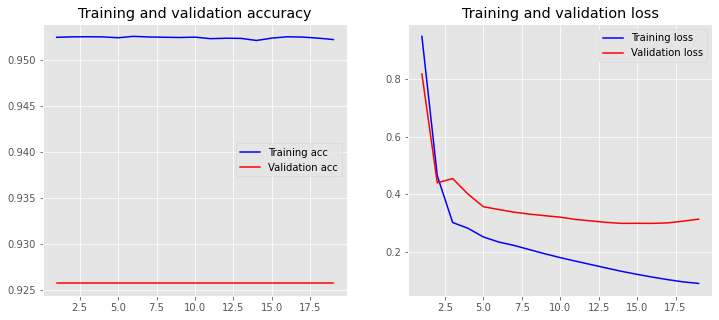

1000/1000 [==============================] - 21s 21ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_7 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 108s 1s/step - l

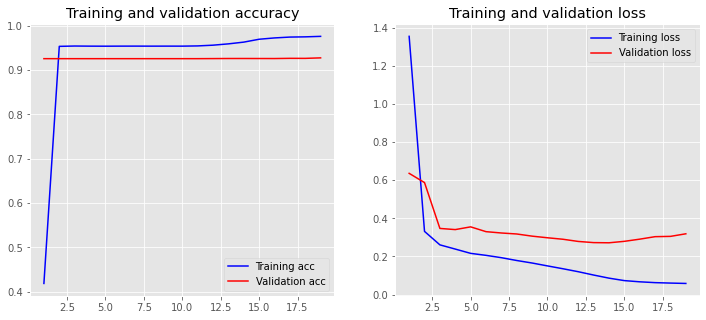

1000/1000 [==============================] - 22s 22ms/step
F1-score: 6.3%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.1513988486011514,0.07384964035865603,0.09927481042418623,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.1513988486011514,0.040115610030240584,0.06342557332656343,37367.0
macro avg,0.0756994243005757,0.036924820179328015,0.049637405212093116,37367.0
weighted avg,0.08224084965092653,0.040115610030240584,0.053926729520436,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_8 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 110s 1s/step - l

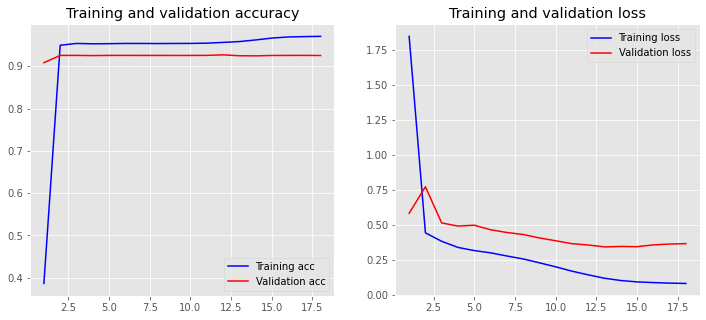

1000/1000 [==============================] - 22s 22ms/step
F1-score: 9.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.13955928646379853,0.013104739383190463,0.023959646910466585,20298.0
Disease,0.2595137420718816,0.11506239381334583,0.15943499614401105,17069.0
micro avg,0.2353810428541271,0.059678325795488,0.09521572980935505,37367.0
macro avg,0.19953651426784008,0.06408356659826815,0.09169732152723882,37367.0
weighted avg,0.19435369336760056,0.059678325795488,0.08584389600906617,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_9 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 111s 1s/step - l

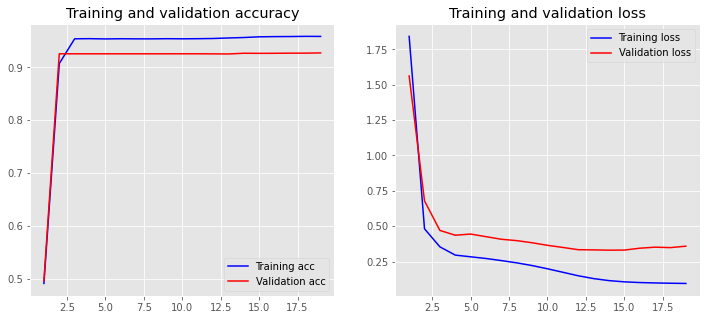

1000/1000 [==============================] - 23s 23ms/step
F1-score: 5.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3974025974025974,0.007537688442211055,0.014794758980805492,20298.0
Disease,0.14815743294058661,0.06924834495283848,0.09438256078572284,17069.0
micro avg,0.1596317111084539,0.03572671073407017,0.05838617975071069,37367.0
macro avg,0.272780015171592,0.03839301669752477,0.05458865988326417,37367.0
weighted avg,0.28354904447616336,0.03572671073407017,0.05114994374297891,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_10 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 88 samples, validate on 1000 samples
Epoch 1/100
88/88 [==============================] - 112s 1s/step - 

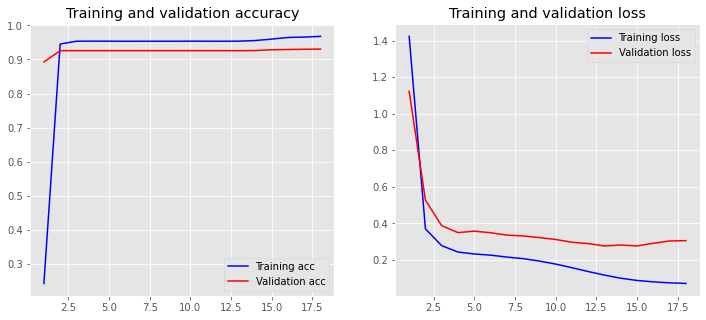

1000/1000 [==============================] - 23s 23ms/step
F1-score: 0.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.022388059701492536,0.0007389890629618681,0.0014307516215185045,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.022388059701492536,0.000401423716113148,0.0007887057338906853,37367.0
macro avg,0.011194029850746268,0.0003694945314809341,0.0007153758107592522,37367.0
weighted avg,0.012161341178603995,0.000401423716113148,0.0007771936846303584,37367.0



In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_3 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 116s 1s/step 

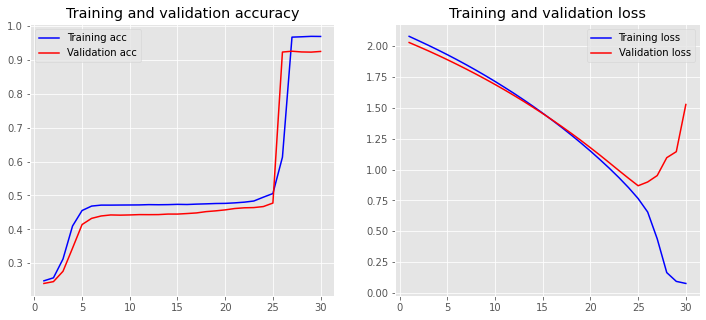

1000/1000 [==============================] - 22s 22ms/step
F1-score: 5.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.026443368501438125,0.41624790619765495,0.04972764271904087,20298.0
Disease,0.6062624916722186,0.053313023610053314,0.09800753904146474,17069.0
micro avg,0.029154491704411645,0.2504616372735301,0.052229331354061735,37367.0
macro avg,0.31635293008682835,0.23478046490385412,0.0738675908802528,37367.0
weighted avg,0.29130093302098886,0.2504616372735301,0.07178158203253816,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_4 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 114s 1s/step 

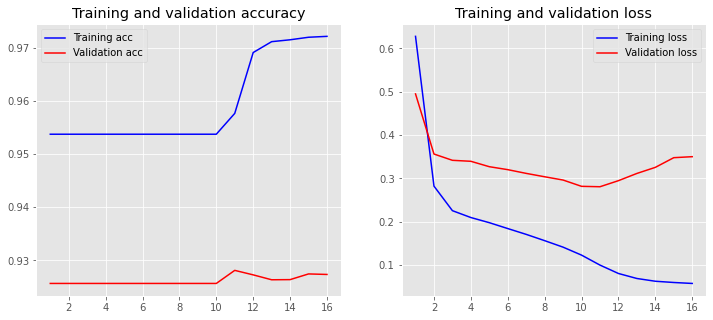

1000/1000 [==============================] - 21s 21ms/step
F1-score: 6.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.23547831532801003,0.07409597004630998,0.11272250327899568,20298.0
Disease,0.024615384615384615,0.0014060577655398677,0.0026601640434493466,17069.0
micro avg,0.20755229557185548,0.04089169588139267,0.06832256477900243,37367.0
macro avg,0.13004684997169733,0.037751013905924925,0.05769133366122251,37367.0
weighted avg,0.13915751450552485,0.04089169588139267,0.06244675011680604,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_5 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 113s 1s/step 

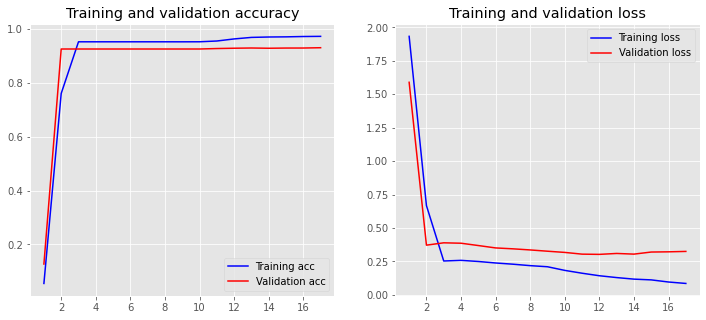

1000/1000 [==============================] - 22s 22ms/step
F1-score: 10.2%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.43860720830788025,0.10611882944132427,0.17089134832797812,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.43860720830788025,0.057644445633848046,0.10189696769005155,37367.0
macro avg,0.21930360415394012,0.05305941472066213,0.08544567416398906,37367.0
weighted avg,0.23825431836201336,0.057644445633848046,0.09282930361980624,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_6 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 115s 1s/step 

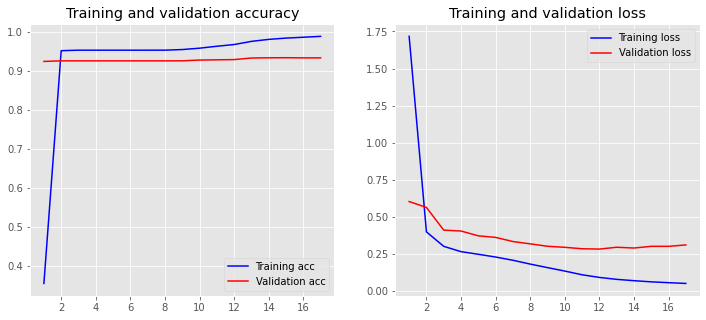

1000/1000 [==============================] - 22s 22ms/step
F1-score: 11.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.43253968253968256,0.005369987190856242,0.010608272506082725,20298.0
Disease,0.2451347973576147,0.16087644267385318,0.19426267199603833,17069.0
micro avg,0.249257901169897,0.07640431396686917,0.1169578664918785,37367.0
macro avg,0.3388372399486486,0.08312321493235471,0.10243547225106053,37367.0
weighted avg,0.34693436273416656,0.07640431396686917,0.0945003950980503,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_7 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 114s 1s/step 

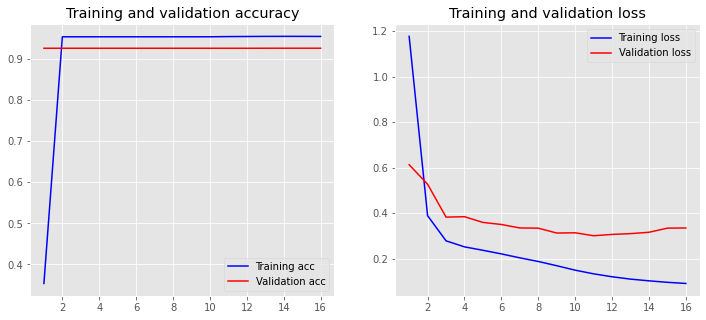

1000/1000 [==============================] - 23s 23ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_8 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 116s 1s/step 

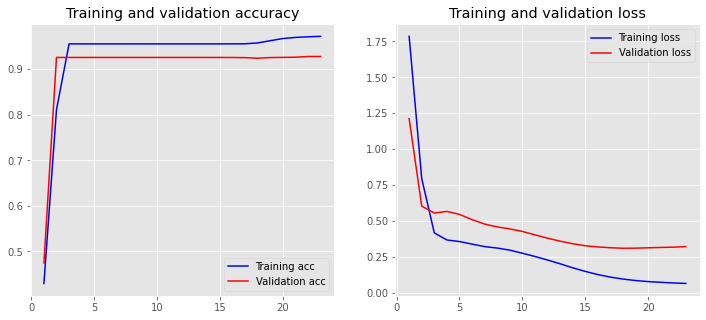

1000/1000 [==============================] - 22s 22ms/step
F1-score: 1.3%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.05306581661353835,0.013942260321213913,0.022082634310015215,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.05306581661353835,0.007573527444001391,0.013255269320843092,37367.0
macro avg,0.026532908306769173,0.006971130160606956,0.011041317155007608,37367.0
weighted avg,0.028825700367211746,0.007573527444001391,0.011995432098501053,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_9 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 115s 1s/step 

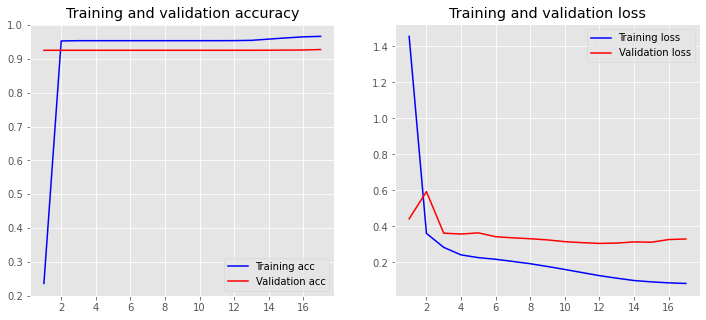

1000/1000 [==============================] - 23s 23ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_10 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 115s 1s/step

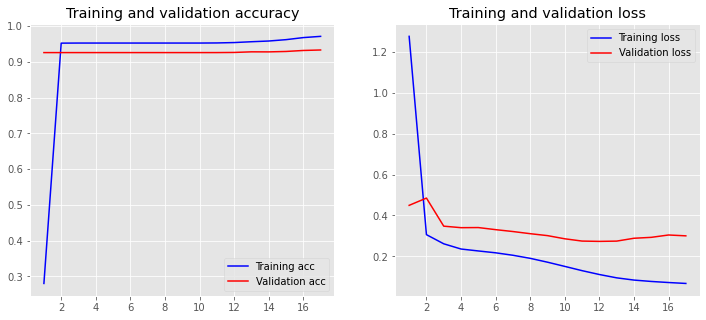

1000/1000 [==============================] - 23s 23ms/step
F1-score: 0.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.06455266138165346,0.0033393871931571856,0.006350267379679145,17069.0
micro avg,0.06361607142857142,0.0015254101212299623,0.002979379557274652,37367.0
macro avg,0.03227633069082673,0.0016696935965785928,0.0031751336898395723,37367.0
weighted avg,0.029487231437456653,0.0015254101212299623,0.0029007604009886616,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_11 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 116s 1s/step

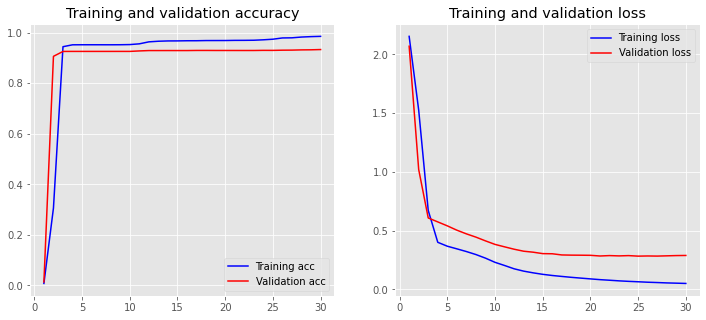

1000/1000 [==============================] - 23s 23ms/step
F1-score: 14.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.39423631123919306,0.03369790127106119,0.06208868515408705,20298.0
Disease,0.26906874607869496,0.1758743921729451,0.21271168426273646,17069.0
micro avg,0.28591374495811356,0.09864318783953756,0.14668019658170675,37367.0
macro avg,0.331652528658944,0.10478614672200315,0.13740018470841175,37367.0
weighted avg,0.33706059015576273,0.09864318783953756,0.13089228115551976,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_12 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 114s 1s/step

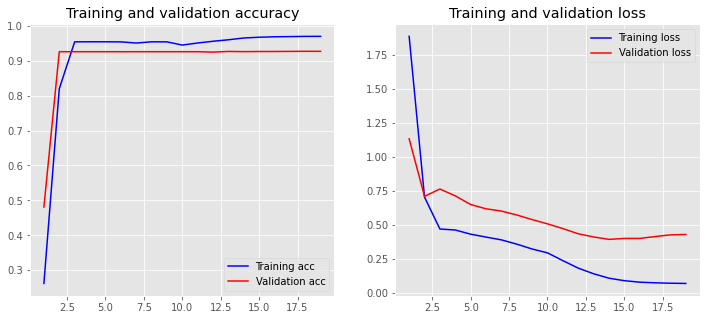

1000/1000 [==============================] - 24s 24ms/step
F1-score: 10.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.1865966779319767,0.15202999589899818,0.1675490702479339,17069.0
micro avg,0.1865966779319767,0.0694463028875746,0.10122089167999376,37367.0
macro avg,0.09329833896598835,0.07601499794949909,0.08377453512396695,37367.0
weighted avg,0.08523613604573314,0.0694463028875746,0.07653531404881268,37367.0



In [14]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_13 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 102s 340ms/s

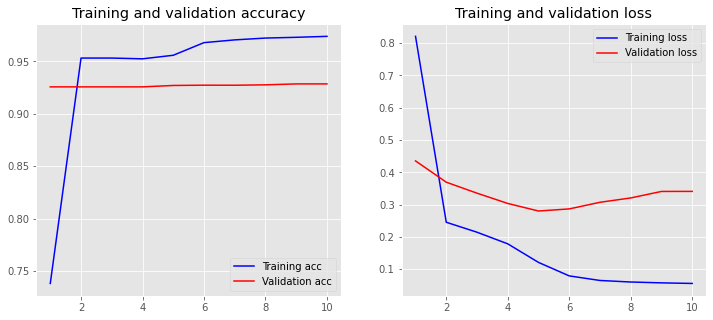

1000/1000 [==============================] - 24s 24ms/step
F1-score: 5.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.18286814244465832,0.077919034507001,0.1092761482211815,17069.0
micro avg,0.17578641289981498,0.03559290282869912,0.05919925221997196,37367.0
macro avg,0.09143407122232916,0.0389595172535005,0.05463807411059075,37367.0
weighted avg,0.08353296554146367,0.03559290282869912,0.04991662627418168,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_14 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 102s 341ms/s

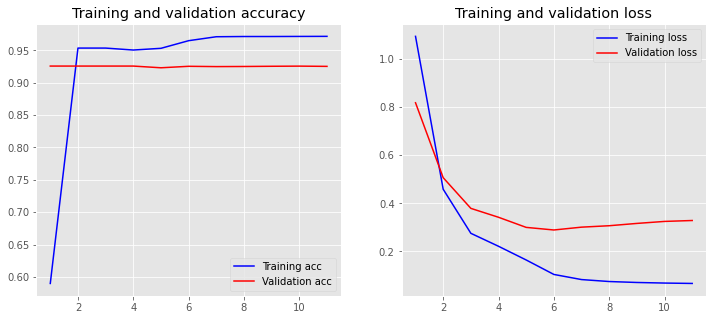

1000/1000 [==============================] - 24s 24ms/step
F1-score: 11.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.23099126471705278,0.14981771603113608,0.18175298090428235,20298.0
Disease,0.01922077922077922,0.002167672388540629,0.0038959671475202696,17069.0
micro avg,0.2039761431411531,0.08237214654641796,0.1173532607659607,37367.0
macro avg,0.12510602196891601,0.07599269420983835,0.09282447402590131,37367.0
weighted avg,0.13425589883443192,0.08237214654641796,0.10050906601108321,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_15 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 104s 347ms/s

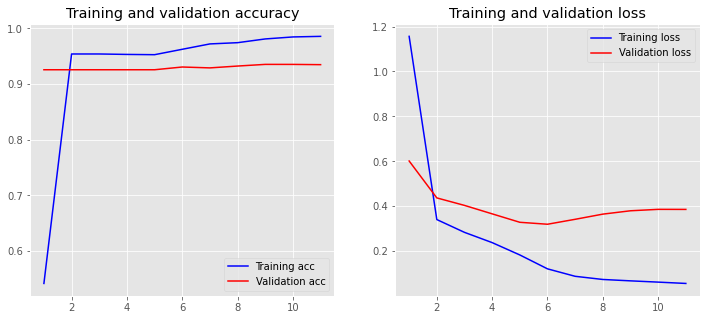

1000/1000 [==============================] - 24s 24ms/step
F1-score: 10.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.808367575644378,0.10661148881663218,0.18837867247007617,20298.0
Disease,0.14864864864864866,0.000644443142539106,0.0012833226389780085,17069.0
micro avg,0.7906215921483097,0.05820643883640646,0.10843013111321602,37367.0
macro avg,0.47850811214651334,0.05362796597958564,0.09483099755452709,37367.0
weighted avg,0.5070123058905818,0.05820643883640646,0.10291474637841737,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_16 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 104s 346ms/s

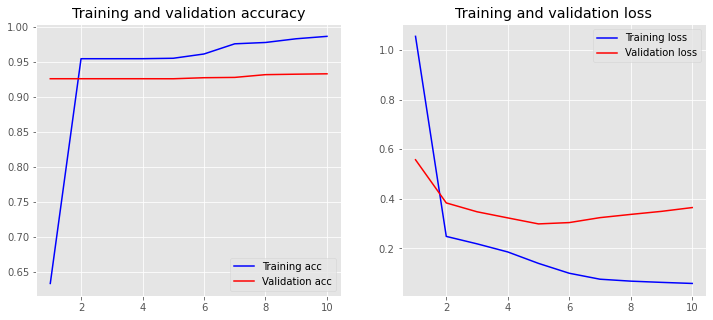

1000/1000 [==============================] - 24s 24ms/step
F1-score: 1.5%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.3475177304964539,0.014484185634052616,0.027809307604994324,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.3475177304964539,0.0078679048358177,0.015387433595896687,37367.0
macro avg,0.17375886524822695,0.007242092817026308,0.013904653802497162,37367.0
weighted avg,0.18877391531610838,0.0078679048358177,0.015106198671720361,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_17 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 104s 345ms/s

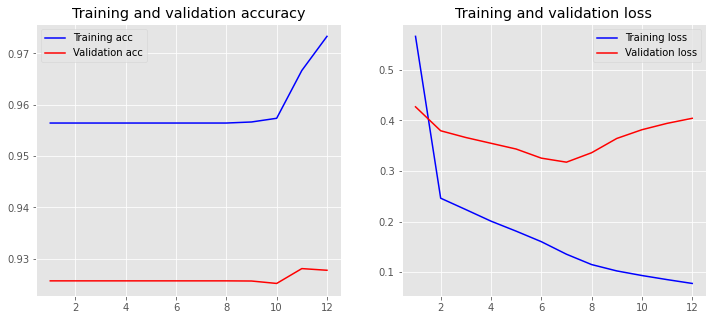

1000/1000 [==============================] - 25s 25ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_18 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 105s 349ms/s

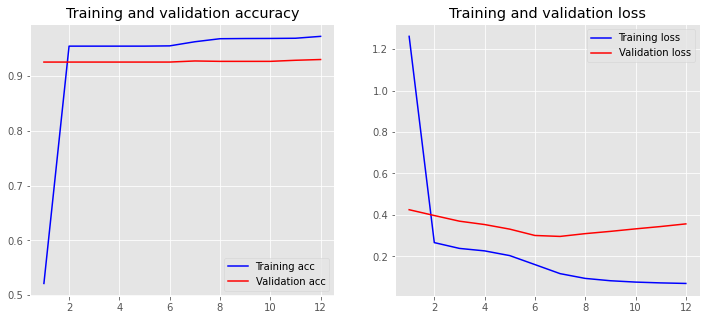

1000/1000 [==============================] - 25s 25ms/step
F1-score: 12.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.2912037508918561,0.16737945983947508,0.21257440476190476,17069.0
micro avg,0.2912037508918561,0.07645783712901759,0.12111577430158124,37367.0
macro avg,0.14560187544592804,0.08368972991973754,0.10628720238095238,37367.0
weighted avg,0.13301995942872297,0.07645783712901759,0.09710259091928579,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_19 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 104s 348ms/s

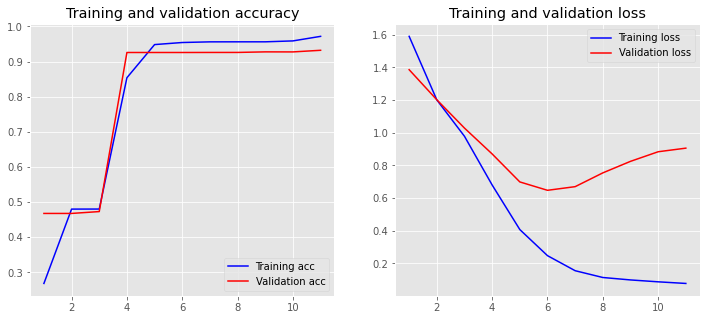

1000/1000 [==============================] - 25s 25ms/step
F1-score: 1.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8481375358166189,0.014582717509114199,0.028672446360246042,20298.0
Disease,0.021865889212827987,0.0008787861034624172,0.0016896648831315122,17069.0
micro avg,0.3004830917874396,0.008322851714079267,0.016197073069110984,37367.0
macro avg,0.4350017125147234,0.007730751806288308,0.015181055621688777,37367.0
weighted avg,0.4707020784376452,0.008322851714079267,0.016346889129725317,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_20 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 104s 348ms/s

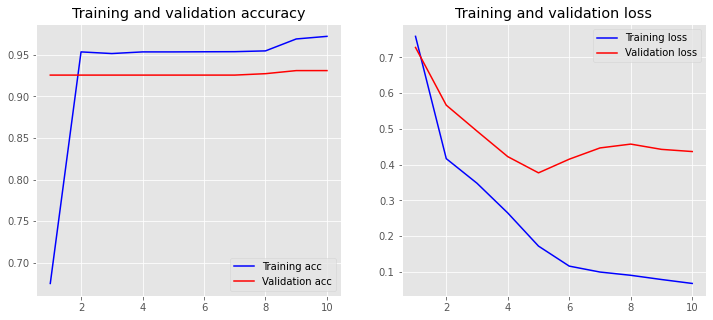

1000/1000 [==============================] - 25s 25ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_21 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 102s 341ms/s

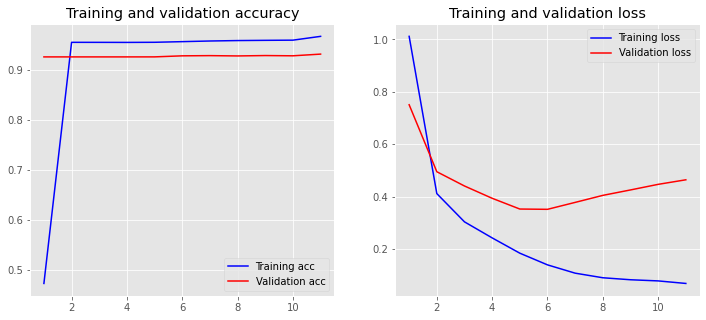

1000/1000 [==============================] - 25s 25ms/step
F1-score: 6.5%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.2404009514101257,0.08289882242662136,0.12328468743193204,17069.0
micro avg,0.2404009514101257,0.03786763722000696,0.0654289875846762,37367.0
macro avg,0.12020047570506286,0.04144941121331068,0.06164234371596602,37367.0
weighted avg,0.10981357453419957,0.03786763722000696,0.05631563491250697,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_22 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 1000 samples
Epoch 1/100
300/300 [==============================] - 101s 337ms/s

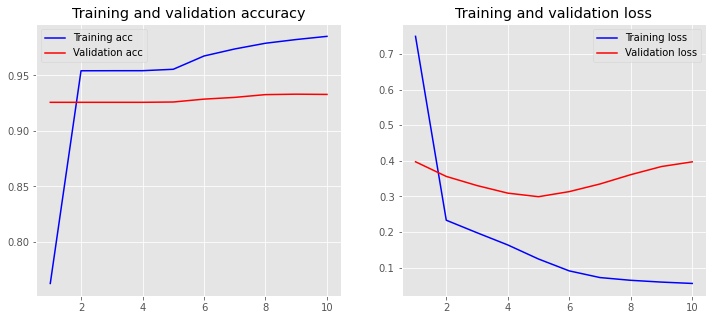

1000/1000 [==============================] - 26s 26ms/step
F1-score: 3.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.24452554744525548,0.0297073603310671,0.05297838692672641,20298.0
Disease,0.025236593059936908,0.000937371843693245,0.0018076032310907753,17069.0
micro avg,0.1996774193548387,0.016565418684935905,0.030592828724639826,37367.0
macro avg,0.13488107025259619,0.015322366087380173,0.027392995078908595,37367.0
weighted avg,0.14435579439034063,0.016565418684935905,0.02960390926192044,37367.0



In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 1000% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_23 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 75s 136ms/st

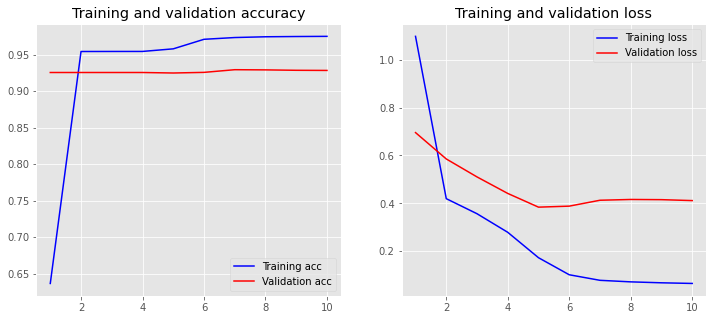

1000/1000 [==============================] - 26s 26ms/step
F1-score: 8.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.16007849733669752,0.11252340132032712,0.13215298269976275,20298.0
Disease,0.038461538461538464,5.8585740230827815e-05,0.00011699327288680901,17069.0
micro avg,0.15985728277598993,0.06115021275456954,0.08846131511198002,37367.0
macro avg,0.09927001789911799,0.05629099353027897,0.06613498798632478,37367.0
weighted avg,0.10452466986753783,0.06115021275456954,0.07183981055516069,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_24 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 74s 135ms/st

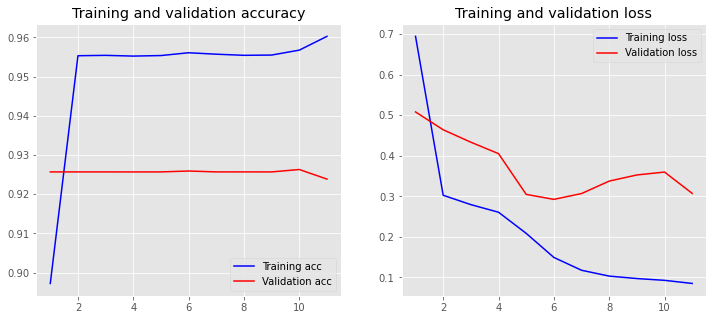

1000/1000 [==============================] - 26s 26ms/step
F1-score: 0.5%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.23950617283950618,0.0056828168023902986,0.01110220899622296,17069.0
micro avg,0.23950617283950618,0.0025958733641983566,0.005136079635708991,37367.0
macro avg,0.11975308641975309,0.0028414084011951493,0.00555110449811148,37367.0
weighted avg,0.10940484556420187,0.0025958733641983566,0.00507141609860384,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_25 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 75s 136ms/st

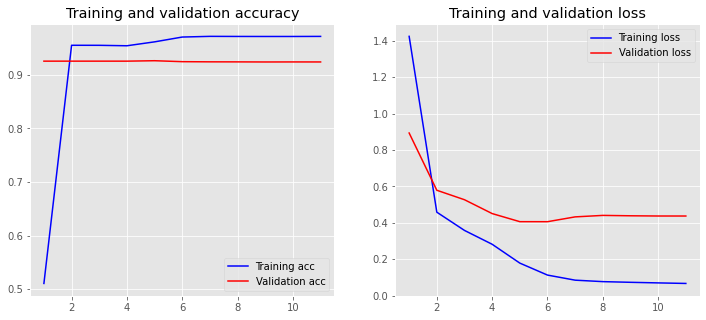

1000/1000 [==============================] - 26s 26ms/step
F1-score: 11.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.20335130220172762,0.1542516504089073,0.17543073259560163,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.2015448986160283,0.08379051034335108,0.11836981588597785,37367.0
macro avg,0.10167565110086381,0.07712582520445364,0.08771536629780081,37367.0
weighted avg,0.11046176391175815,0.08379051034335108,0.09529512698973751,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_26 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 75s 135ms/st

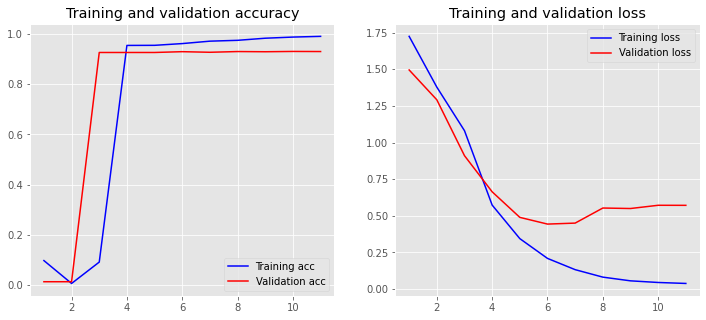

1000/1000 [==============================] - 26s 26ms/step
F1-score: 10.9%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.26383896477354424,0.1265641935166026,0.17106708839687032,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.26383896477354424,0.06875050177964515,0.10907778532608696,37367.0
macro avg,0.13191948238677212,0.0632820967583013,0.08553354419843516,37367.0
weighted avg,0.14331905978466028,0.06875050177964515,0.09292476678030545,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_27 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 75s 136ms/st

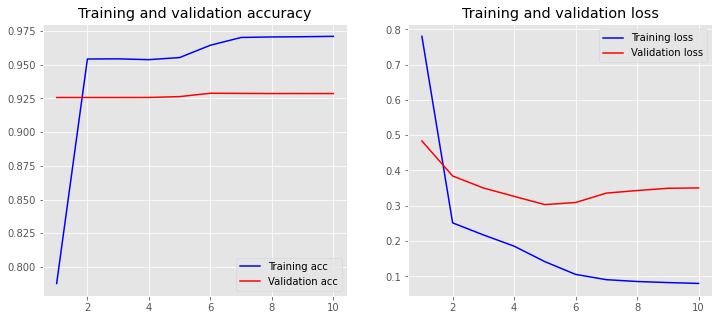

1000/1000 [==============================] - 26s 26ms/step
F1-score: 0.5%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.09935897435897435,0.005448473841466987,0.010330463760066647,17069.0
micro avg,0.09935897435897435,0.0024888270399015173,0.004856016500013054,37367.0
macro avg,0.049679487179487176,0.0027242369207334935,0.005165231880033323,37367.0
weighted avg,0.04538652643598184,0.0024888270399015173,0.004718887947134573,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_28 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 74s 135ms/st

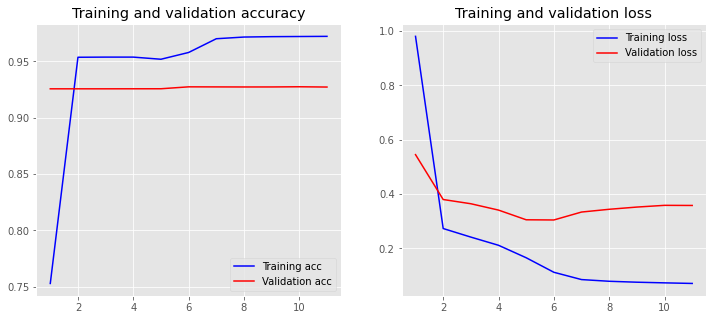

1000/1000 [==============================] - 26s 26ms/step
F1-score: 10.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.03333333333333333,4.926593753079121e-05,9.838646202282567e-05,20298.0
Disease,0.2137279079325935,0.15232292460015232,0.17787507696517751,17069.0
micro avg,0.2132841328413284,0.06960687237401986,0.10495944473588636,37367.0
macro avg,0.12353062063296341,0.07618609526884156,0.08898673171360016,37367.0
weighted avg,0.11573638934090075,0.06960687237401986,0.08130561022091028,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_29 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_29 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 74s 135ms/st

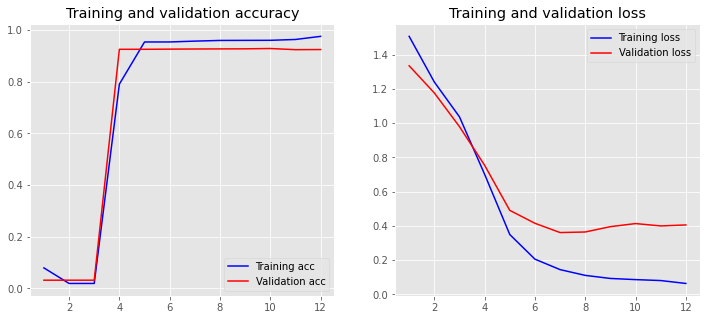

1000/1000 [==============================] - 26s 26ms/step
F1-score: 3.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.004338394793926247,0.0003941275002463297,0.000722608617107759,20298.0
Disease,0.14602196108649587,0.044407991094967486,0.06810422282120396,17069.0
micro avg,0.10888415067519545,0.020499371102844756,0.03450295031755326,37367.0
macro avg,0.07518017794021106,0.02240105929760691,0.034413415719155856,37367.0
weighted avg,0.06905851664068599,0.020499371102844756,0.031502087110155584,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_30 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_30 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 73s 133ms/st

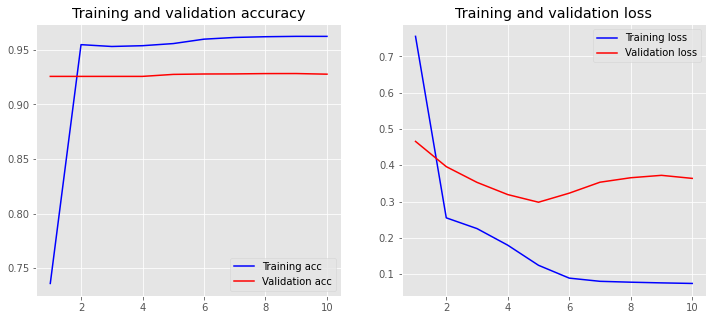

1000/1000 [==============================] - 27s 27ms/step
F1-score: 2.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.1299515531490453,0.026715097545257485,0.04431917581883565,17069.0
micro avg,0.11890482398956975,0.012203280969839699,0.02213484782292122,37367.0
macro avg,0.06497577657452265,0.013357548772628743,0.022159587909417824,37367.0
weighted avg,0.05936101535314728,0.012203280969839699,0.020244708219865275,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_31 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_31 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 74s 135ms/st

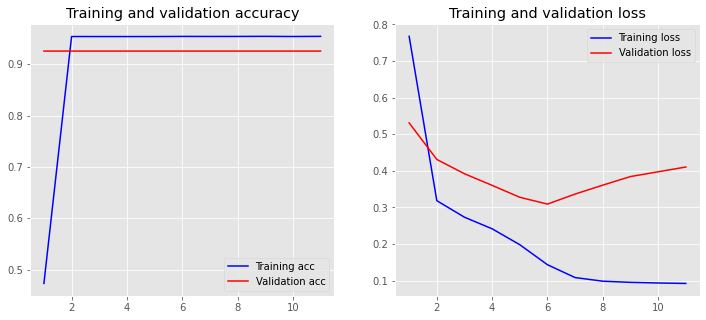

1000/1000 [==============================] - 27s 27ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,1.0,0.00034486156271553846,0.0006894853484363457,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,1.0,0.00018733106751946905,0.0003745919623267512,37367.0
macro avg,0.5,0.00017243078135776923,0.00034474267421817287,37367.0
weighted avg,0.5432065726443118,0.00018733106751946905,0.0003745329730125765,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 550
Points in y_train after augmentation: 550


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_32 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_32 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 550 samples, validate on 1000 samples
Epoch 1/100
550/550 [==============================] - 77s 140ms/st

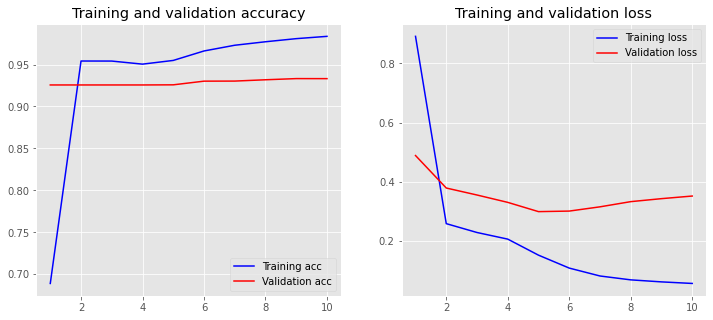

1000/1000 [==============================] - 28s 28ms/step
F1-score: 2.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3561058923996584,0.020543895950339935,0.03884670920862639,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.3492462311557789,0.011159579307945514,0.021628069811467546,37367.0
macro avg,0.1780529461998292,0.010271947975169967,0.019423354604313194,37367.0
weighted avg,0.19343906130886251,0.011159579307945514,0.021101787767728166,37367.0



In [16]:
number_of_training_models = 10
target_augmented_percentage = 10

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)